In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import googlemaps
import os
import requests
import numpy as np
from datetime import timedelta
from scipy.stats import skew, kurtosis, entropy
import pandas as pd
import numpy as np
import random 
import math
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis
from scipy import stats
import random
from tqdm import tqdm
import warnings
import json
import joblib

import pywt

In [3]:
# Read the CSV file with no initial parsing
df_raw = pd.read_csv("./Data/raw/ENERGY_DATA_MYT.csv", header=None)  # Read the data as a single column

# Expand the single column into multiple columns based on commas
df = df_raw[0].str.split(',', expand=True)

# Set columns the first row 
df.columns = df.iloc[0]

# Remove the ID from columns the first column
df = df.drop(columns=[df.columns[0]])

# Remove the first row
df = df.drop(index=0)

df

,ZIP_CODE,SQUARE_METERS,INVOICE_DATE,ENERGY_CONSUMPTION,TAX_ID,SUPPLY_ID
1,15235,95.0,2023-10-05,1572.0,383,1542
2,13123,98.0,2023-10-05,127.0,1212,187
3,63080,114.0,2023-10-05,927.0,1664,505
4,11527,131.0,2023-10-05,1520.0,1083,318
5,32005,,2023-10-05,1421.0,646,879
...,...,...,...,...,...,...
8226,85102,149.0,2022-10-05,936.0,1771,992
8227,11364,,2022-10-05,566.0,1508,24
8228,18546,67.0,2022-10-05,963.0,1114,1111
8229,42100,90.0,2022-10-05,1548.0,275,804


In [4]:
#Check how many different IDs exist
print(len(df['SUPPLY_ID'].unique()))

# #check how many NaNs are in the "SQUARE_METER" feature
# nans_sm = np.where(df['SQUARE_METERS'].isna())
# print(len(nans_sm[0]))

2000


In [5]:
#Group by the different IDs
grouped_df = df.groupby('SUPPLY_ID')

# Accessing the groups
groups = grouped_df.groups
no_meas = []
for supply_id, indices in list(groups.items()):
     # Accessing the original DataFrame using the indices
    no_meas.append(len(df.loc[indices]))

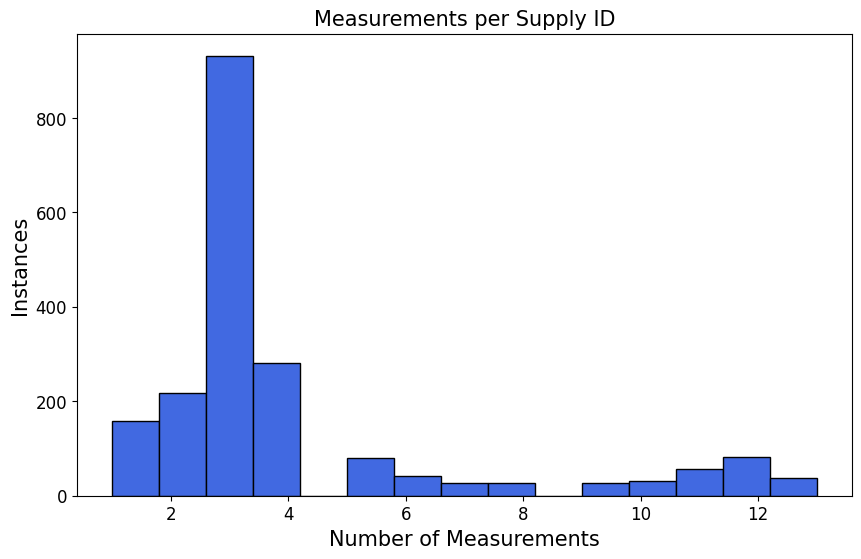

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(no_meas, bins=15, color='royalblue', edgecolor='black')
plt.title('Measurements per Supply ID',fontsize=15)
plt.xlabel('Number of Measurements',fontsize=15)
plt.ylabel('Instances',fontsize=15)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

In [7]:
# #Use Google API to find the latitude and the longitude for the different zip codes
# def extract_lat_long_via_address(address_or_zipcode, country='Greece'):
#     """Fetch latitude and longitude for a given address/zipcode from Google Maps API."""
#     with open("config.json") as config_file:
#         config = json.load(config_file)
#         GOOGLE_API_KEY = config["GOOGLE_API_KEY"]
#     try:
#         endpoint = f"https://maps.googleapis.com/maps/api/geocode/json?address={address_or_zipcode}&components=country:{country}&key={GOOGLE_API_KEY}"
#         response = requests.get(endpoint)
#         if response.status_code == 200:
#             result = response.json()['results'][0]
#             return result['geometry']['location']['lat'], result['geometry']['location']['lng']
#     except (IndexError, KeyError):
#         return None, None

In [8]:
# df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)
# df[['LATITUDE', 'LONGITUDE']] = df['ZIP_CODE'].apply(extract_lat_long_via_address).apply(pd.Series)

In [9]:
#Save the results to a new Dataframe containing the ID, latitude, longitude
lat_long_df = df[["SUPPLY_ID", "LATITUDE", "LONGITUDE"]].copy()

#Save to csv
lat_long_df.to_csv('Data/lat_long_df.csv', index = False)

KeyError: "['LATITUDE', 'LONGITUDE'] not in index"

In [85]:
df.to_csv('Data/Dataset_mytilinaios_with lat_long.csv',index=False)

Index(['ZIP_CODE', 'SQUARE_METERS', 'INVOICE_DATE', 'ENERGY_CONSUMPTION',
       'TAX_ID', 'SUPPLY_ID'],
      dtype='object', name=0)


## Start from here !

In [77]:
df = pd.read_csv('Data/Dataset_mytilinaios_with lat_long.csv')
print(df.columns)

na = df.isna().sum()
print(na)

Index(['ZIP_CODE', 'SQUARE_METERS', 'INVOICE_DATE', 'ENERGY_CONSUMPTION',
       'TAX_ID', 'SUPPLY_ID', 'LATITUDE', 'LONGITUDE'],
      dtype='object')
ZIP_CODE               28
SQUARE_METERS         733
INVOICE_DATE            0
ENERGY_CONSUMPTION      0
TAX_ID                  0
SUPPLY_ID               0
LATITUDE                0
LONGITUDE               0
dtype: int64


In [78]:
#check how many NaNs are in the "SQUARE_METER" feature
nans_sm = np.where(df['SQUARE_METERS'].isna())
print(len(nans_sm[0]))

print(df.shape)
df = df.dropna(axis=0)
print(df.shape)


na = df.isna().sum()
print(na)

733
(8230, 8)
(7475, 8)
ZIP_CODE              0
SQUARE_METERS         0
INVOICE_DATE          0
ENERGY_CONSUMPTION    0
TAX_ID                0
SUPPLY_ID             0
LATITUDE              0
LONGITUDE             0
dtype: int64


In [79]:
#this grouping is done before
grouped_df = df.groupby('SUPPLY_ID')

# Accessing the groups
groups = grouped_df.groups
#crete a dictionary in which the keys are the SUPPLY ID and the value is a datframe that has info for every user
data_dict = {}
# Displaying the first few groups for demonstration
for supply_id, indices in list(groups.items()):
    
     data_dict[supply_id] = df.loc[indices]

In [80]:
data_dict[list(data_dict.keys())[90]]

,ZIP_CODE,SQUARE_METERS,INVOICE_DATE,ENERGY_CONSUMPTION,TAX_ID,SUPPLY_ID,LATITUDE,LONGITUDE
957,11853.0,70.0,2023-09-05,346.0,356,100,37.969511,23.706834
6259,11853.0,70.0,2023-01-05,470.0,356,100,37.969511,23.706834


In [81]:
#List of keys to be removed
single_row_keys = [key for key, value in data_dict.items() if len(value) == 1]
keys_removed = [key for key in single_row_keys]

for key in keys_removed:
    data_dict.pop(key, None)
    
zero_cons_keys = [key for key,value in data_dict.items() if value["ENERGY_CONSUMPTION"].iloc[0] == 0.0]
keys_removed = [key for key in zero_cons_keys ]
for key in keys_removed:
    data_dict.pop(key, None)

In [82]:
def create_lists(dataframe):
    # Convert 'INVOICE_DATE' to datetime format
    dataframe['INVOICE_DATE'] = pd.to_datetime(dataframe['INVOICE_DATE'])

    # Ensure 'ENERGY_CONSUMPTION' is float
    dataframe['ENERGY_CONSUMPTION'] = pd.to_numeric(dataframe['ENERGY_CONSUMPTION'], errors='coerce')

    # Handle missing or invalid energy consumption values
    if dataframe['ENERGY_CONSUMPTION'].isnull().any():
        print("Warning: NaN values in ENERGY_CONSUMPTION! Filling with 0.")
        dataframe['ENERGY_CONSUMPTION'].fillna(0, inplace=True)

    # Extract the minimum and maximum dates
    min_date = dataframe['INVOICE_DATE'].min()
    max_date = dataframe['INVOICE_DATE'].max()

    # Calculate the start date (min_date - 120 days)
    start_date = min_date - timedelta(days=120)

    # Generate a list of dates
    date_list = pd.date_range(start=start_date, end=max_date).tolist()
    date_list_str = [date.strftime('%Y-%m-%d') for date in date_list]

    # Sort the dataframe by 'INVOICE_DATE'
    dataframe = dataframe.sort_values(by='INVOICE_DATE')

    # Calculate 'DAYS_BETWEEN_DATES'
    dataframe['DAYS_BETWEEN_DATES'] = dataframe['INVOICE_DATE'].diff().dt.days

    # Calculate daily consumption safely
    dataframe['DAILY_CONSUMPTION'] = (
        dataframe['ENERGY_CONSUMPTION'] / dataframe['DAYS_BETWEEN_DATES']
    )
    
    # Handle the first invoice
    first_invoice = dataframe['DAYS_BETWEEN_DATES'].isna()
    dataframe.loc[first_invoice, 'DAILY_CONSUMPTION'] = (
        dataframe['ENERGY_CONSUMPTION'] / 120
    )

    # Drop the intermediate column
    dataframe.drop(columns='DAYS_BETWEEN_DATES', inplace=True)

    # Initialize daily consumption list
    daily_consumption_list_total = []
    daily_cons = dataframe['DAILY_CONSUMPTION'].iloc[0]
    cnt = 0

    # Populate daily consumption list
    for date in date_list_str:
        if date == dataframe['INVOICE_DATE'].iloc[-1].strftime('%Y-%m-%d'):
            daily_cons = dataframe['DAILY_CONSUMPTION'].iloc[cnt]
        elif date == dataframe['INVOICE_DATE'].iloc[cnt].strftime('%Y-%m-%d'):
            daily_cons = dataframe['DAILY_CONSUMPTION'].iloc[cnt + 1]
            cnt += 1
        daily_consumption_list_total.append(daily_cons)

    # Split the daily consumption list
    daily_cons_past = [
        value for value in daily_consumption_list_total if value != daily_consumption_list_total[-1]
    ]
    daily_labels = [
        value for value in daily_consumption_list_total if value == daily_consumption_list_total[-1]
    ]

    # Calculate the mean of daily labels
    mean_daily_labels = np.mean(daily_labels)

    return date_list_str, daily_consumption_list_total, daily_labels, daily_cons_past, mean_daily_labels

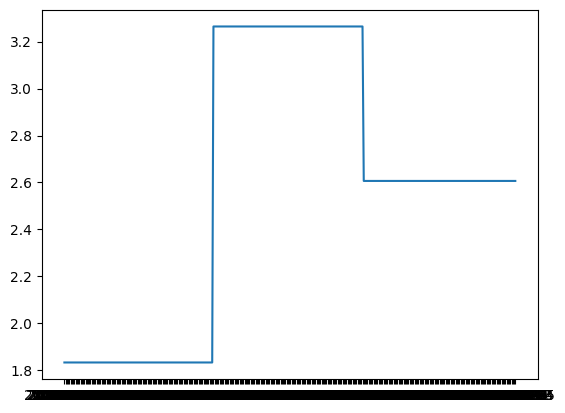

In [83]:
#check if the function works
test_df = data_dict[list(data_dict.keys())[90]]
date_list_str, daily_consumption_list_total, daily_labels, daily_cons_past, mean_daily_labels = create_lists(test_df)
# print(date_list_str)
# print(daily_consumption_list_total)
# print(daily_labels)
# print(daily_cons)
# print(mean_daily_labels)
plt.plot(date_list_str, daily_consumption_list_total)

# Aux Functions for time series feature extracrion

In [84]:
def calculate_center_of_energy(wave, energy):
    wave = np.array(wave)
    energy_center = 0
    if energy == 0:
        return 1
    for i in range(wave.shape[0]):
        if np.isnan(wave[i]):
            wave[i] = 0
            #print('Calculation of COE: Wave is nan')
        energy_center+= i* wave[i]**2
    #print(energy_center)
    energy_center/=energy
    return energy_center

def calculate_energy(wave):
    energy = 0
    wave = np.array(wave)
    for i in range(wave.shape[0]):
        if np.isnan(wave[i]):
            wave[i] = 0
        energy+= wave[i]**2
    return energy

def dwt_features(signal):
    """
    Compute extended features of a signal using wavelet transform.

    Parameters:
    signal (list of float): The input signal.

    Returns:
    dict: A dictionary containing various wavelet features.
    """

    # Convert the signal to a numpy array
    signal = np.array(signal)

    # Perform Discrete Wavelet Transform
    coeffs = pywt.dwt(signal, 'haar')

    # Decompose into approximation and detail coefficients
    cA, cD = coeffs

    # Function to calculate entropy
    def entropy(x):
        return -np.sum(x * np.log2(x + np.finfo(float).eps))

    # Compute various features
    wavelet_features = {
        'MEAN_APPROXIMATION': np.mean(cA),
        'STD_APPROXIMATION': np.std(cA),
        'MEAN_DETAIL': np.mean(cD),
        'STD_DETAIL': np.std(cD),
        'ENERGY_APPROXIMATION': np.sum(cA ** 2),
        'ENERGY_DETAIL': np.sum(cD ** 2),
        'ENTROPY_APPROXIMATION': entropy(cA),
        'ENTROPY_DETAIL': entropy(cD),
        'MAX_APPROXIMATION': np.max(cA),
        'MAX_DETAIL': np.max(cD),
        'MIN_APPROXIMATION': np.min(cA),
        'MIN_DETAIL': np.min(cD),
        'VARIANCE_APPROXIMATION': np.var(cA),
        'VARIANCE_DETAIL': np.var(cD)
    }
    
    wavelet_feats = list(wavelet_features.values())
    wavelet_feats_names = list(wavelet_features.keys())
    
    return wavelet_feats, wavelet_feats_names

def calc_entropy(x):
    return -np.sum(x * np.log2(x + np.finfo(float).eps))

# Features

In [85]:
warnings.filterwarnings("ignore")

dataset_df = pd.DataFrame(columns = ['ID','mean','std','max','min','p2p','rms','lat','long','size','SKEW','KURT','ENERGY','ENTROPY','CREST',
                                     'MEAN_APPROXIMATION','STD_APPROXIMATION','MEAN_DETAIL','STD_DETAIL','ENERGY_APPROXIMATION','ENERGY_DETAIL',
                                     'ENTROPY_APPROXIMATION','ENTROPY_DETAIL','MAX_APPROXIMATION','MAX_DETAIL','MIN_APPROXIMATION','MIN_DETAIL','VARIANCE_APPROXIMATION','VARIANCE_DETAIL','label'])

feature_dict = {}

for key in data_dict.keys():
    key_df = data_dict[key]
    date_list_str, daily_consumption_list_total, daily_labels, daily_cons_past, mean_daily_labels = create_lists(key_df)
    
    mean_value = np.mean(daily_cons_past)
    std_value = np.std(daily_cons_past)
    max_value = np.max(daily_cons_past)
    min_value = np.min(daily_cons_past)
    p2p_value = np.ptp(daily_cons_past)
    rms_value = np.sqrt(np.mean(np.square(daily_cons_past)))
    
    skewn = skew(daily_cons_past, bias=True)
    kurt = kurtosis(daily_cons_past, bias=True)
    energy = calculate_energy(daily_cons_past)
    entropy = calc_entropy(np.array(daily_cons_past))
    crest_f = np.amax(abs(np.array(daily_cons_past)))/rms_value
    
    dwt_feats, dwt_feats_names = dwt_features(daily_cons_past)
    
    latitude = key_df['LATITUDE'].iloc[0]
    longitude = key_df['LONGITUDE'].iloc[0]
    size = key_df['SQUARE_METERS'].iloc[0]
    
    features_list = [int(key),mean_value,std_value,max_value,min_value,p2p_value,rms_value,latitude,longitude,size,skewn,kurt,energy,entropy,crest_f] + dwt_feats + [mean_daily_labels]
    
    dataset_df.loc[key] = features_list

In [86]:
na = dataset_df.isna().sum()
print(na)

ID                          0
mean                        0
std                         0
max                         0
min                         0
p2p                         0
rms                         0
lat                         0
long                        0
size                        0
SKEW                      191
KURT                      191
ENERGY                      0
ENTROPY                     0
CREST                      13
MEAN_APPROXIMATION          0
STD_APPROXIMATION           0
MEAN_DETAIL                 0
STD_DETAIL                  0
ENERGY_APPROXIMATION        0
ENERGY_DETAIL               0
ENTROPY_APPROXIMATION       0
ENTROPY_DETAIL            388
MAX_APPROXIMATION           0
MAX_DETAIL                  0
MIN_APPROXIMATION           0
MIN_DETAIL                  0
VARIANCE_APPROXIMATION      0
VARIANCE_DETAIL             0
label                       0
dtype: int64


In [87]:
dataset_df

,ID,mean,std,max,min,p2p,rms,lat,long,size,...,ENERGY_DETAIL,ENTROPY_APPROXIMATION,ENTROPY_DETAIL,MAX_APPROXIMATION,MAX_DETAIL,MIN_APPROXIMATION,MIN_DETAIL,VARIANCE_APPROXIMATION,VARIANCE_DETAIL,label
2,2.0,5.125000,0.000000e+00,5.125000,5.125000,0.000000,5.125000,37.961787,23.751396,79.0,...,0.000000,-1242.665556,-0.0,7.247845,0.000000,7.247845,0.00000,3.155444e-30,0.000000,5.404959
4,4.0,4.809129,4.074345e-01,5.214876,4.400000,0.814876,4.826357,38.002447,23.733089,98.0,...,0.000000,-2281.533650,-0.0,7.374948,0.000000,6.222540,0.00000,3.319888e-01,0.000000,6.295082
5,5.0,0.758333,2.220446e-16,0.758333,0.758333,0.000000,0.758333,38.010464,23.700732,44.0,...,0.000000,-6.492844,-0.0,1.072445,0.000000,1.072445,0.00000,0.000000e+00,0.000000,0.075000
6,6.0,10.771350,3.419571e+00,15.300000,7.024390,8.275610,11.301126,39.074208,21.824312,53.0,...,34.242858,-11108.654733,NaN,21.637468,0.000000,9.933988,-5.85174,2.324691e+01,0.187114,9.975410
8,8.0,4.825000,8.881784e-16,4.825000,4.825000,0.000000,4.825000,37.996899,23.740664,45.0,...,0.000000,-1134.295626,-0.0,6.823580,0.000000,6.823580,0.00000,7.888609e-31,0.000000,12.573034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1996.0,3.541667,4.440892e-16,3.541667,3.541667,0.000000,3.541667,39.762755,19.818698,50.0,...,0.000000,-698.538121,-0.0,5.008673,0.000000,5.008673,0.00000,7.888609e-31,0.000000,14.175824
1997,1997.0,5.776081,4.733003e+00,18.266667,1.900000,16.366667,7.467558,39.762755,19.818698,116.0,...,167.437741,-5551.333788,NaN,25.832968,10.661599,2.687006,-7.16839,4.400102e+01,0.849893,21.290323
1998,1998.0,0.120833,7.916667e-02,0.200000,0.041667,0.158333,0.144458,39.762755,19.818698,129.0,...,0.000000,45.361668,-0.0,0.282843,0.000000,0.058926,0.00000,1.253472e-02,0.000000,0.243902
1999,1999.0,5.315353,6.708964e-01,5.983471,4.641667,1.341804,5.357525,39.762755,19.818698,35.0,...,0.000000,-2659.515236,-0.0,8.461906,0.000000,6.564308,0.00000,9.001580e-01,0.000000,3.106557


In [88]:
dataset_df.to_csv('Data/Processed_dataset',index=False)

In [89]:
nas = dataset_df.isna().sum()
print(nas)

ID                          0
mean                        0
std                         0
max                         0
min                         0
p2p                         0
rms                         0
lat                         0
long                        0
size                        0
SKEW                      191
KURT                      191
ENERGY                      0
ENTROPY                     0
CREST                      13
MEAN_APPROXIMATION          0
STD_APPROXIMATION           0
MEAN_DETAIL                 0
STD_DETAIL                  0
ENERGY_APPROXIMATION        0
ENERGY_DETAIL               0
ENTROPY_APPROXIMATION       0
ENTROPY_DETAIL            388
MAX_APPROXIMATION           0
MAX_DETAIL                  0
MIN_APPROXIMATION           0
MIN_DETAIL                  0
VARIANCE_APPROXIMATION      0
VARIANCE_DETAIL             0
label                       0
dtype: int64


## Replace NaN values

In [90]:
nan_features = ['SKEW', 'KURT', 'CREST', 'ENTROPY_DETAIL']

for feat in nan_features:
        if dataset_df[feat].isnull().any():
                print("Warning: NaN values in ENERGY_CONSUMPTION! Filling with 0.")
                dataset_df[feat].fillna(-1, inplace=True)

# # Round the dataset to 6 decimal places
# dataset_df = dataset_df.round(6)

# # Convert each column to float32
# for col in dataset_df.columns:
#     dataset_df[col] = dataset_df[col].astype("float32")

    

In [91]:
nas = dataset_df.isna().sum()
print(nas)

ID                        0
mean                      0
std                       0
max                       0
min                       0
p2p                       0
rms                       0
lat                       0
long                      0
size                      0
SKEW                      0
KURT                      0
ENERGY                    0
ENTROPY                   0
CREST                     0
MEAN_APPROXIMATION        0
STD_APPROXIMATION         0
MEAN_DETAIL               0
STD_DETAIL                0
ENERGY_APPROXIMATION      0
ENERGY_DETAIL             0
ENTROPY_APPROXIMATION     0
ENTROPY_DETAIL            0
MAX_APPROXIMATION         0
MAX_DETAIL                0
MIN_APPROXIMATION         0
MIN_DETAIL                0
VARIANCE_APPROXIMATION    0
VARIANCE_DETAIL           0
label                     0
dtype: int64


### Outliers handling

In [92]:

print("Shape before dropping outliers:", dataset_df.shape)

# Calculate the Q1, Q3, and IQR for the 'label' column
Q1 = dataset_df['label'].quantile(0.25)
Q3 = dataset_df['label'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values greater than Q3 + 3*IQR or less than Q1 - 3*IQR
outliers = (dataset_df['label'] < (Q1 - 3.0 * IQR)) | (dataset_df['label'] > (Q3 + 3.0 * IQR))

# Print how many extreme outliers exist
print("Number of extreme outliers:", outliers.sum())

# Drop the rows with outliers in the 'label' column
dataset_df= dataset_df[~outliers]

print("Shape after dropping outliers:", dataset_df.shape)

Shape before dropping outliers: (1636, 30)
Number of extreme outliers: 19
Shape after dropping outliers: (1617, 30)


## Save the preprocessed dataset

In [93]:
# Save the whole processed dataset
dataset_df.to_csv("Data/Processed_dataset.csv")

## Split the dataset in two halves

In [94]:
# half1, half2 = train_test_split(dataset_df, test_size=0.5)

# # Save the halves as needed
# half1.to_csv("Data/Processed_data_half1.csv", index=False)
# half2.to_csv("Data/Processed_data_half2.csv", index=False)

In [95]:
# Assuming the last column is the target variable
y = dataset_df.iloc[:, -1].values  # Target variable
X = dataset_df.iloc[:, :-1].values  # Features

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Perform scaling so we can have scaled & preprocessed datasets to be used in shamrock framework!!!!
# Compute 2nd (q5) and 98th (q95) quantiles for feature scaling
q5_X = np.quantile(X_train, 0.02, axis=0)
q95_X = np.quantile(X_train, 0.98, axis=0)

# Apply scaling to features
X_train_norm = (X_train - q5_X) / (q95_X - q5_X)
X_test_norm = (X_test - q5_X) / (q95_X - q5_X)

# Compute 2nd (q5) and 98th (q95) quantiles for target scaling
q5_y = np.quantile(y_train, 0.02, axis=0)
q95_y = np.quantile(y_train, 0.98, axis=0)

# Apply scaling to target variable
y_train_norm = (y_train - q5_y) / (q95_y - q5_y)
y_test_norm = (y_test - q5_y) / (q95_y - q5_y)

In [97]:
# Save the feature quantiles (q5_X, q95_X)
joblib.dump((q5_X, q95_X), "./scalers/feature_scaler.pkl")

# Save the target quantiles (q5_y, q95_y)
joblib.dump((q5_y, q95_y), "./scalers/target_scaler.pkl")

['./scalers/target_scaler.pkl']

In [98]:
# Convert back to DataFrame
train_df = pd.DataFrame(np.column_stack((X_train_norm, y_train_norm)), columns=dataset_df.columns)
test_df = pd.DataFrame(np.column_stack((X_test_norm, y_test_norm)), columns=dataset_df.columns)

# Save the new datasets
train_df.to_csv("Data/Train_dataset.csv", index=False)
test_df.to_csv("Data/Test_dataset.csv", index=False)

print("Datasets successfully split and scaled.")

Datasets successfully split and scaled.


In [99]:
train_df.columns

Index(['ID', 'mean', 'std', 'max', 'min', 'p2p', 'rms', 'lat', 'long', 'size',
       'SKEW', 'KURT', 'ENERGY', 'ENTROPY', 'CREST', 'MEAN_APPROXIMATION',
       'STD_APPROXIMATION', 'MEAN_DETAIL', 'STD_DETAIL',
       'ENERGY_APPROXIMATION', 'ENERGY_DETAIL', 'ENTROPY_APPROXIMATION',
       'ENTROPY_DETAIL', 'MAX_APPROXIMATION', 'MAX_DETAIL',
       'MIN_APPROXIMATION', 'MIN_DETAIL', 'VARIANCE_APPROXIMATION',
       'VARIANCE_DETAIL', 'label'],
      dtype='object')